# Flight Status - Final Project

In [186]:
import os
import shutil
import warnings
import zipfile

import pandas as pd
from scipy import stats
#import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sqlalchemy import create_engine
import psycopg2
from dotenv import load_dotenv
import sqlite3

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC


from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_curve, roc_auc_score
from pickle import dump

warnings.filterwarnings('ignore')

## TAS-12 Data Acquisition

### Data Acquisition - Use Kaggle API

[How to use Kaggle API - Step-by-step guide](https://www.geeksforgeeks.org/how-to-download-kaggle-datasets-into-jupyter-notebook/)

Since almost all combined CSV files are larger than 60k records and more than 20 columns the best course of action would be to only use one year data, in this case we are going to use the `Combined_Flights_2022.csv` with the shape `(4078318, 61)` and the `Airlines.csv` for labeling if needed

The **Data Acquisition - Use Kaggle API** section can be re-run only in case we need to access the data from the kaggle API again. After this section we cleaned the data and saved it as CSV in the `/data/processed/` folder, accessed from there, then we'll create a DB with 2 tables `airlines` and `flights`, with the corresponding data and we'll work the data by retrieving it from the DB tables

In [2]:
!kaggle datasets files robikscube/flight-delay-dataset-20182022

name                            size  creationDate         
-----------------------------  -----  -------------------  
Combined_Flights_2018.parquet  215MB  2022-10-07 16:28:11  
Combined_Flights_2021.parquet  232MB  2022-10-07 16:28:11  
Combined_Flights_2019.parquet  294MB  2022-10-07 16:28:11  
Combined_Flights_2018.csv        2GB  2022-10-07 16:28:11  
readme.md                       36KB  2022-10-07 16:28:11  
Combined_Flights_2019.csv        3GB  2022-10-07 16:28:11  
readme.html                     14KB  2022-10-07 16:28:11  
Airlines.csv                    38KB  2022-10-07 16:28:11  
Combined_Flights_2022.parquet  143MB  2022-10-07 16:28:11  
Combined_Flights_2022.csv        1GB  2022-10-07 16:28:11  
Combined_Flights_2020.csv        2GB  2022-10-07 16:28:11  
Combined_Flights_2021.csv        2GB  2022-10-07 16:28:11  
Combined_Flights_2020.parquet  175MB  2022-10-07 16:28:11  


In [3]:
!kaggle datasets download robikscube/flight-delay-dataset-20182022 -f Combined_Flights_2022.csv --path ../data/processed


  0%|          | 0.00/206M [00:00<?, ?B/s]
  0%|          | 1.00M/206M [00:00<00:47, 4.51MB/s]
  3%|▎         | 6.00M/206M [00:00<00:09, 22.6MB/s]
  5%|▍         | 10.0M/206M [00:00<00:07, 28.2MB/s]
  8%|▊         | 16.0M/206M [00:00<00:05, 38.9MB/s]
 10%|█         | 21.0M/206M [00:00<00:05, 38.6MB/s]
 13%|█▎        | 26.0M/206M [00:00<00:05, 37.1MB/s]
 15%|█▍        | 30.0M/206M [00:00<00:04, 37.7MB/s]
 17%|█▋        | 34.0M/206M [00:01<00:04, 36.5MB/s]
 18%|█▊        | 38.0M/206M [00:01<00:04, 35.5MB/s]
 20%|██        | 42.0M/206M [00:01<00:05, 34.0MB/s]
 22%|██▏       | 46.0M/206M [00:01<00:05, 31.7MB/s]
 24%|██▍       | 50.0M/206M [00:01<00:05, 32.0MB/s]
 26%|██▌       | 54.0M/206M [00:01<00:05, 31.2MB/s]
 28%|██▊       | 58.0M/206M [00:01<00:05, 30.7MB/s]
 30%|██▉       | 61.0M/206M [00:02<00:05, 30.2MB/s]
 32%|███▏      | 65.0M/206M [00:02<00:04, 30.5MB/s]
 33%|███▎      | 68.0M/206M [00:02<00:05, 26.1MB/s]
 34%|███▍      | 71.0M/206M [00:02<00:05, 26.1MB/s]
 36%|███▌      | 74.

In [4]:
!kaggle datasets download robikscube/flight-delay-dataset-20182022 -f Airlines.csv --path ../data/processed --unzip 

Airlines.csv: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
with zipfile.ZipFile('../data/processed/Combined_Flights_2022.csv.zip', 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall('../data/processed/')

In [6]:
def remove_compressed():
    os.remove('../data/processed/Combined_Flights_2022.csv.zip')

In [7]:
remove_compressed()

### Data Acquisition - Clean and Store Data to CSV

In [8]:
data = pd.read_csv('../data/processed/Combined_Flights_2022.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078318 entries, 0 to 4078317
Data columns (total 61 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   FlightDate                               object 
 1   Airline                                  object 
 2   Origin                                   object 
 3   Dest                                     object 
 4   Cancelled                                bool   
 5   Diverted                                 bool   
 6   CRSDepTime                               int64  
 7   DepTime                                  float64
 8   DepDelayMinutes                          float64
 9   DepDelay                                 float64
 10  ArrTime                                  float64
 11  ArrDelayMinutes                          float64
 12  AirTime                                  float64
 13  CRSElapsedTime                           float64
 14  ActualElapsedTime 

In [10]:
data = data.sample(
    n = 500000,
    random_state = 42
)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 3811797 to 818443
Data columns (total 61 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   FlightDate                               500000 non-null  object 
 1   Airline                                  500000 non-null  object 
 2   Origin                                   500000 non-null  object 
 3   Dest                                     500000 non-null  object 
 4   Cancelled                                500000 non-null  bool   
 5   Diverted                                 500000 non-null  bool   
 6   CRSDepTime                               500000 non-null  int64  
 7   DepTime                                  485442 non-null  float64
 8   DepDelayMinutes                          485439 non-null  float64
 9   DepDelay                                 485439 non-null  float64
 10  ArrTime                        

In [12]:
data.describe()

,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,...,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,DistanceGroup,DivAirportLandings
count,500000.000000,485442.000000,485439.000000,485439.000000,484973.000000,483825.000000,483825.000000,500000.000000,483825.000000,500000.000000,...,485165.000000,485165.000000,484972.000000,484972.000000,500000.000000,483825.000000,483825.000000,483825.000000,500000.000000,500000.000000
mean,1329.120830,1333.669225,16.100501,13.176115,1457.545614,15.867810,111.126192,141.433184,135.964690,798.916914,...,16.968201,1355.691816,1454.706041,7.882546,1485.733588,7.609537,0.216299,-0.058467,3.666546,0.003784
std,490.729503,505.963408,52.437194,53.445160,543.018210,52.165167,70.018200,71.843747,71.938226,591.845864,...,9.492607,507.930657,537.736098,6.678576,518.277098,55.430586,0.411721,2.497218,2.321489,0.116592
min,1.000000,1.000000,0.000000,-55.000000,1.000000,0.000000,8.000000,5.000000,16.000000,31.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-91.000000,0.000000,-2.000000,1.000000,0.000000
25%,914.000000,917.000000,0.000000,-5.000000,1046.000000,0.000000,60.000000,89.000000,83.000000,368.000000,...,11.000000,932.000000,1044.000000,4.000000,1102.000000,-14.000000,0.000000,-1.000000,2.000000,0.000000
50%,1320.000000,1325.000000,0.000000,-1.000000,1459.000000,0.000000,94.000000,125.000000,119.000000,646.000000,...,15.000000,1338.000000,1456.000000,6.000000,1512.000000,-5.000000,0.000000,-1.000000,3.000000,0.000000
75%,1735.000000,1743.000000,11.000000,11.000000,1913.000000,10.000000,141.000000,172.000000,167.000000,1035.000000,...,19.000000,1757.000000,1908.000000,9.000000,1920.000000,10.000000,0.000000,0.000000,5.000000,0.000000
max,2359.000000,2400.000000,2650.000000,2650.000000,2400.000000,2678.000000,673.000000,690.000000,711.000000,5095.000000,...,183.000000,2400.000000,2400.000000,251.000000,2359.000000,2678.000000,1.000000,12.000000,11.000000,9.000000


In [13]:
def check_nulls(df):
    # Assuming df is your DataFrame
    # Check for null values in each column
    percentage = 10
    percent = (percentage * len(df)) / 100
    null_counts = df.isnull().sum()

    # Filter columns with null values and print their sum
    columns_with_nulls_ten = null_counts[null_counts > percent]
    columns_with_nulls = null_counts[null_counts > 0]
    if len(columns_with_nulls_ten) > 0:
        for column, count in columns_with_nulls.items():
            print(f"Column '{column}' has {count} null values.")
    else:
        print("The null values in the dataframe don't exceed {percent} values or {percentage}% of the total data".format(percent=percent, percentage=percentage))
        print("Depending on Duplicated values we might want to consider dropping them since that low percentage of null values would hardly make any difference in the EDA or the model creation and prediction")

In [14]:
check_nulls(data)

The null values in the dataframe don't exceed 50000.0 values or 10% of the total data
Depending on Duplicated values we might want to consider dropping them since that low percentage of null values would hardly make any difference in the EDA or the model creation and prediction


In [15]:
# data.duplicated().sum()

In [16]:
def treat_nulls(value):
    if pd.isnull(value):
        return 0
    else:
        return int(value)
    
# Define a function to transform values
def transform_time(value):
    if isinstance(value, int):
        value = str(value)  # Convert integer to string
    value = value.zfill(4)  # Pad with leading zeros if necessary
    if len(value) == 4:
        if int(value) == 2400:
            return '00:00'
        if int(value) < 10:  # For values less than 10
            return f'00:0{value[0]}'
        elif int(value) < 100:  # For values between 10 and 100
            return f'00:{value[:2]}'
        else:  # For values over 100
            return f'{value[:2]}:{value[2:]}'
    else:
        return value[:2] + ':' + value[2:]  # Format as 'HH:MM'

In [17]:
def format_dates():
    data['FlightDate'] = pd.to_datetime(data['FlightDate'])

    # Format time WheelsOff
    data['WheelsOff'] = data['WheelsOff'].apply(treat_nulls)
    data['WheelsOff'] = data['WheelsOff'].apply(transform_time)
    data['WheelsOff'] = pd.to_datetime(data['WheelsOff'], format='%H:%M').dt.time

    # Format time WheelsOn
    data['WheelsOn'] = data['WheelsOn'].apply(treat_nulls)
    data['WheelsOn'] = data['WheelsOn'].apply(transform_time)
    data['WheelsOn'] = pd.to_datetime(data['WheelsOn'], format='%H:%M').dt.time

    # Format time ArrTime
    data['ArrTime'] = data['ArrTime'].apply(treat_nulls)
    data['ArrTime'] = data['ArrTime'].apply(transform_time)
    data['ArrTime'] = pd.to_datetime(data['ArrTime'], format='%H:%M').dt.time


    # Format time DepTime
    data['DepTime'] = data['DepTime'].apply(treat_nulls)
    data['DepTime'] = data['DepTime'].apply(transform_time)
    data['DepTime'] = pd.to_datetime(data['DepTime'], format='%H:%M').dt.time

In [18]:
format_dates()

In [19]:
data['DepPeriod'] = 'Night'
data['ArrPeriod'] = 'Night'

# Update 'DepPeriod' based on conditions
data.loc[(data['DepTime'] >= pd.to_datetime('00:00:00').time()) & (data['DepTime'] < pd.to_datetime('06:00:00').time()), 'DepPeriod'] = 'Night'
data.loc[(data['DepTime'] >= pd.to_datetime('06:00:00').time()) & (data['DepTime'] < pd.to_datetime('12:00:00').time()), 'DepPeriod'] = 'Morning'
data.loc[(data['DepTime'] >= pd.to_datetime('12:00:00').time()) & (data['DepTime'] < pd.to_datetime('18:00:00').time()), 'DepPeriod'] = 'Afternoon'
data.loc[(data['DepTime'] >= pd.to_datetime('18:00:00').time()) & (data['DepTime'] <= pd.to_datetime('23:59:59').time()), 'DepPeriod'] = 'Evening'


# Update 'DepPeriod' based on conditions
data.loc[(data['ArrTime'] >= pd.to_datetime('00:00:00').time()) & (data['ArrTime'] < pd.to_datetime('06:00:00').time()), 'ArrPeriod'] = 'Night'
data.loc[(data['ArrTime'] >= pd.to_datetime('06:00:00').time()) & (data['ArrTime'] < pd.to_datetime('12:00:00').time()), 'ArrPeriod'] = 'Morning'
data.loc[(data['ArrTime'] >= pd.to_datetime('12:00:00').time()) & (data['ArrTime'] < pd.to_datetime('18:00:00').time()), 'ArrPeriod'] = 'Afternoon'
data.loc[(data['ArrTime'] >= pd.to_datetime('18:00:00').time()) & (data['ArrTime'] <= pd.to_datetime('23:59:59').time()), 'ArrPeriod'] = 'Evening'


data.drop(['ArrTime', 'DepTime'], axis=1, inplace=True)

In [20]:
data['ArrDelayCat'] = 'On Time'
data['DepDelayCat'] = 'On Time'

data.loc[(data['ArrDelay'] < 0), 'ArrDelayCat'] = 'Early'
data.loc[(data['ArrDelay'] > 0) & (data['ArrDelay'] < 10), 'ArrDelayCat'] = 'On Time'
data.loc[(data['ArrDelay'] > 10), 'ArrDelayCat'] = 'Late'

data.loc[(data['DepDelay'] < 0), 'DepDelayCat'] = 'Early'
data.loc[(data['DepDelay'] > 0) & (data['DepDelay'] < 10), 'DepDelayCat'] = 'On Time'
data.loc[(data['DepDelay'] > 10), 'DepDelayCat'] = 'Late'

In [21]:
origins = data[['OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac']]
origins.drop_duplicates(inplace=True)
origins.to_csv('../data/processed/origins.csv', index = False)

In [22]:
destinations = data[['DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac']]
destinations.drop_duplicates(inplace=True)
destinations.to_csv('../data/processed/destinations.csv', index = False)

In [23]:
data.drop(
    columns=[
        'CRSDepTime',
        'ActualElapsedTime',
        'CRSArrTime',
        'OriginAirportSeqID',
        'OriginCityMarketID',
        'Origin',
        'OriginCityName',
        'OriginState',
        'OriginStateFips',
        'OriginStateName',
        'OriginWac',
        'TaxiIn',
        'TaxiOut',
        'ArrDel15',
        'ArrivalDelayGroups',
        'ArrTimeBlk',
        'DistanceGroup',
        'CRSDepTime',
        'DepDel15',
        'DepartureDelayGroups',
        'DepTimeBlk',
        'DestAirportSeqID',
        'DestCityMarketID',
        'Dest',
        'DestCityName',
        'DestState',
        'DestStateFips',
        'DestStateName',
        'DestWac',
        'CRSArrTime',
        'CRSElapsedTime',
        'FlightDate',
        'Diverted',
        'DepDelayMinutes',
        'ArrDelayMinutes',
        'Year',
        'Quarter',
        'DayofMonth',
        'DayOfWeek',
        'Tail_Number',
        'WheelsOn',
        'WheelsOff',
    ], 
    inplace=True
)

In [24]:
colms = data.columns

print(colms)

Index(['Airline', 'Cancelled', 'DepDelay', 'AirTime', 'Distance', 'Month',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Flight_Number_Operating_Airline', 'OriginAirportID', 'DestAirportID',
       'ArrDelay', 'DivAirportLandings', 'DepPeriod', 'ArrPeriod',
       'ArrDelayCat', 'DepDelayCat'],
      dtype='object')


In [25]:
data.to_csv('../data/processed/Combined_Flights_2022.csv', index = False)

In [26]:
data = pd.read_csv('../data/processed/Combined_Flights_2022.csv')
origins = pd.read_csv('../data/processed/origins.csv')
destinations = pd.read_csv('../data/processed/destinations.csv')
airlines = pd.read_csv('../data/processed/Airlines.csv')

In [27]:
data.columns

Index(['Airline', 'Cancelled', 'DepDelay', 'AirTime', 'Distance', 'Month',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Flight_Number_Operating_Airline', 'OriginAirportID', 'DestAirportID',
       'ArrDelay', 'DivAirportLandings', 'DepPeriod', 'ArrPeriod',
       'ArrDelayCat', 'DepDelayCat'],
      dtype='object')

In [28]:
data.head()

,Airline,Cancelled,DepDelay,AirTime,Distance,Month,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,IATA_Code_Operating_Airline,Flight_Number_Operating_Airline,OriginAirportID,DestAirportID,ArrDelay,DivAirportLandings,DepPeriod,ArrPeriod,ArrDelayCat,DepDelayCat
0,SkyWest Airlines Inc.,False,-5.0,31.0,125.0,3,UA,UA_CODESHARE,19977,UA,...,OO,5745,10372,11292,-10.0,0,Evening,Evening,Early,Early
1,SkyWest Airlines Inc.,False,0.0,194.0,1162.0,2,UA,UA_CODESHARE,19977,UA,...,OO,5733,15412,11292,35.0,0,Afternoon,Evening,Late,On Time
2,American Airlines Inc.,False,-5.0,314.0,2486.0,1,AA,AA,19805,AA,...,AA,205,12892,13830,3.0,0,Afternoon,Evening,On Time,Early
3,Southwest Airlines Co.,False,18.0,251.0,2106.0,1,WN,WN,19393,WN,...,WN,312,12889,10821,27.0,0,Afternoon,Evening,Late,Late
4,Delta Air Lines Inc.,False,-6.0,73.0,501.0,7,DL,DL,19790,DL,...,DL,698,11433,14492,-16.0,0,Morning,Morning,Early,Early


In [29]:
data.Cancelled.dtype

dtype('bool')

In [30]:
origins.head()

,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac
0,10372,1037205,30372,ASE,"Aspen, CO",CO,8,Colorado,82
1,15412,1541205,35412,TYS,"Knoxville, TN",TN,47,Tennessee,54
2,12892,1289208,32575,LAX,"Los Angeles, CA",CA,6,California,91
3,12889,1288903,32211,LAS,"Las Vegas, NV",NV,32,Nevada,85
4,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43


In [31]:
destinations.head()

,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac
0,11292,1129202,30325,DEN,"Denver, CO",CO,8,Colorado,82
1,13830,1383002,33830,OGG,"Kahului, HI",HI,15,Hawaii,2
2,10821,1082106,30852,BWI,"Baltimore, MD",MD,24,Maryland,35
3,14492,1449202,34492,RDU,"Raleigh/Durham, NC",NC,37,North Carolina,36
4,14869,1486903,34614,SLC,"Salt Lake City, UT",UT,49,Utah,87


In [32]:
airlines.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


From a bussines perspective point of view I wouldn't impute null values, since, for example, DepTime might be null because the flight might have been cancelled and if we impute or drop that registry we might affect the future predictions or even the hypothesis

### Data Acquisition - Database Creation

In [33]:
load_dotenv()

con = sqlite3.connect("../flight-information.db")
cur = con.cursor()

In [34]:
def map_to_bool(cols):
    mapping = {True: 1, False: 0}
    cols = list(cols)

    for c in cols:
        # Convert boolean values to integers (0 and 1)
        data[c] = data[c].astype(int)
    # for c in cols:
    #     #data[c] = data[c].map(mapping)
    #     data[c] = data[c].astype('int')

In [35]:
# map_to_bool(['Cancelled', 'Diverted'])

In [36]:
# data['Diverted'].unique()

In [37]:
airlines.columns

Index(['Code', 'Description'], dtype='object')

In [38]:
airlines_cols = {
    'Code': 'VARCHAR(50)', 
    'Description': 'VARCHAR(100)'
}

orgs_cols = {
    'OriginAirportID': 'INTEGER',
    'OriginAirportSeqID': 'INTEGER',
    'OriginCityMarketID': 'INTEGER',
    'Origin': 'VARCHAR(10)',
    'OriginCityName': 'VARCHAR(60)',
    'OriginState': 'VARCHAR(10)',
    'OriginStateFips': 'INTEGER',
    'OriginStateName': 'VARCHAR(60)',
    'OriginWac': 'INTEGER',
}
dests_cols = {
    'DestAirportID': 'INTEGER',
    'DestAirportSeqID': 'INTEGER',
    'DestCityMarketID': 'INTEGER',
    'Dest': 'VARCHAR(10)',
    'DestCityName': 'VARCHAR(60)',
    'DestState': 'VARCHAR(10)',
    'DestStateFips': 'INTEGER',
    'DestStateName': 'VARCHAR(60)',
    'DestWac': 'INTEGER',
}

main_cols = {
    'Airline': 'VARCHAR(100)',
    'Cancelled': 'BOOLEAN',
    'DepDelay': 'NUMERIC',
    'AirTime': 'NUMERIC',
    'ArrDelayCat': 'VARCHAR(25)',
    'DepDelayCat': 'VARCHAR(25)',
    'ArrPeriod': 'VARCHAR(25)',
    'DepPeriod': 'VARCHAR(25)',
    'Distance': 'NUMERIC',
    'Month': 'INT',
    'Marketing_Airline_Network': 'VARCHAR(10)',
    'Operated_or_Branded_Code_Share_Partners': 'VARCHAR(20)',
    'DOT_ID_Marketing_Airline': 'INT',
    'IATA_Code_Marketing_Airline': 'VARCHAR(10)',
    'Flight_Number_Marketing_Airline': 'INT',
    'Operating_Airline': 'VARCHAR(5)',
    'DOT_ID_Operating_Airline': 'INT',
    'IATA_Code_Operating_Airline': 'VARCHAR(5)',
    'Flight_Number_Operating_Airline': 'INT',
    'OriginAirportID': 'INT',
    'DestAirportID': 'INT',
    'ArrDelay': 'NUMERIC',
    'DivAirportLandings': 'INT' 
}

In [39]:
main_table = f"""
CREATE TABLE flights(
    {", ".join([f"{col} {dtype}" for col, dtype in main_cols.items()])}
)
"""
origins_table = f"""
CREATE TABLE origins(
    {", ".join([f"{col} {dtype}" for col, dtype in orgs_cols.items()])}
)
"""
dests_table = f"""
CREATE TABLE destinations(
    {", ".join([f"{col} {dtype}" for col, dtype in dests_cols.items()])}
)
"""
airlines_table = f"""
CREATE TABLE airlines(
    {", ".join([f"{col} {dtype}" for col, dtype in airlines_cols.items()])}
)
"""

con.execute(main_table)
con.execute(origins_table)
con.execute(dests_table)
con.execute(airlines_table)





# Iterate over rows in the DataFrame and insert data using parameterized queries
for index, row in data.iterrows():
    # Define the SQL query with placeholders for parameters
    insert_sql = f"""
    INSERT INTO flights ({", ".join(main_cols.keys())}) 
    VALUES ({", ".join(['?' for _ in main_cols.keys()])})
    """
    # Extract values from the row as a tuple
    values = tuple(row[col] for col in main_cols.keys())
    
    # Execute the SQL statement with parameterized values
    cur.execute(insert_sql, values)

# Commit the transaction
con.commit()


for index, row in origins.iterrows():
    # Define the SQL query with placeholders for parameters
    insert_sql = f"""
    INSERT INTO origins ({", ".join(orgs_cols.keys())}) 
    VALUES ({", ".join(['?' for _ in orgs_cols.keys()])})
    """
    # Extract values from the row as a tuple
    values = tuple(row[col] for col in orgs_cols.keys())
    
    # Execute the SQL statement with parameterized values
    cur.execute(insert_sql, values)

# Commit the transaction
con.commit()


for index, row in destinations.iterrows():
    # Define the SQL query with placeholders for parameters
    insert_sql = f"""
    INSERT INTO destinations ({", ".join(dests_cols.keys())}) 
    VALUES ({", ".join(['?' for _ in dests_cols.keys()])})
    """
    # Extract values from the row as a tuple
    values = tuple(row[col] for col in dests_cols.keys())
    
    # Execute the SQL statement with parameterized values
    cur.execute(insert_sql, values)

# Commit the transaction
con.commit()


for index, row in airlines.iterrows():
    # Define the SQL query with placeholders for parameters
    insert_sql = f"""
    INSERT INTO airlines ({", ".join(airlines_cols.keys())}) 
    VALUES ({", ".join(['?' for _ in airlines_cols.keys()])})
    """
    # Extract values from the row as a tuple
    values = tuple(row[col] for col in airlines_cols.keys())
    
    # Execute the SQL statement with parameterized values
    cur.execute(insert_sql, values)

# Commit the transaction
con.commit()

### Data Acquisition - Queries to obtain the data

In [40]:
def get_information():
    sql_query = """
    SELECT 
    flights.*, 
    destinations.DestAirportSeqID,
    destinations.DestCityMarketID,
    destinations.Dest,
    destinations.DestCityName,
    destinations.DestState,
    destinations.DestStateFips,
    destinations.DestStateName,
    destinations.DestWac,
    origins.OriginAirportSeqID,
    origins.OriginCityMarketID,
    origins.Origin,
    origins.OriginCityName,
    origins.OriginState,
    origins.OriginStateFips,
    origins.OriginStateName,
    origins.OriginWac
    FROM flights
    INNER JOIN origins ON flights.OriginAirportID = origins.OriginAirportID
    INNER JOIN destinations ON flights.DestAirportID = destinations.DestAirportID
    """
    return pd.read_sql_query(sql_query, con)

In [41]:
df = get_information()

In [42]:
cur.close()
con.close()

## TAS-19 Descriptive Analysis

First of all, let's talk about concise facts with this data. This dataset has been extracted from the Marketing Carrier On-Time Performance which happened in 2022, the original dataset contains the data of 5 years (2018 to 2022). At the same time this was originally collected from *The Bureau of Transportation Statistics (United States Department of Transportation)*, you can checked on https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGK&QO_fu146_anzr=b0-gvzr and the author or the idea of taking this data originally was made by Rob Mulla(https://www.linkedin.com/in/rob-mulla/) a data scientist with more than 6 years of experience and many contributions made in kaggle(https://www.kaggle.com/robikscube). Therefore our data establishes professional standards to guide the methods and procedures for the collection, processing, storage, and presentation of statistical data which assures us to have reliable data in which we trust.

Our main goal is to make contributions to a status prediction which involves certain airlines in the USA. It's important to mention that our data is precise which ensures us to have the right data in order to make predictions and collaborate with right conclusions.

Once we have gotten enough columns to understand how flights delay goes on, we consider seeing the final columns which we are understanding, *it's appropriate to say there were some columns we've dropped, the reason lies in the fact we only are considering on predict something about flights which have already been made*. Let's take a quick look on the data we own:

In [43]:
data.head(10)

,Airline,Cancelled,DepDelay,AirTime,Distance,Month,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,IATA_Code_Operating_Airline,Flight_Number_Operating_Airline,OriginAirportID,DestAirportID,ArrDelay,DivAirportLandings,DepPeriod,ArrPeriod,ArrDelayCat,DepDelayCat
0,SkyWest Airlines Inc.,False,-5.0,31.0,125.0,3,UA,UA_CODESHARE,19977,UA,...,OO,5745,10372,11292,-10.0,0,Evening,Evening,Early,Early
1,SkyWest Airlines Inc.,False,0.0,194.0,1162.0,2,UA,UA_CODESHARE,19977,UA,...,OO,5733,15412,11292,35.0,0,Afternoon,Evening,Late,On Time
2,American Airlines Inc.,False,-5.0,314.0,2486.0,1,AA,AA,19805,AA,...,AA,205,12892,13830,3.0,0,Afternoon,Evening,On Time,Early
3,Southwest Airlines Co.,False,18.0,251.0,2106.0,1,WN,WN,19393,WN,...,WN,312,12889,10821,27.0,0,Afternoon,Evening,Late,Late
4,Delta Air Lines Inc.,False,-6.0,73.0,501.0,7,DL,DL,19790,DL,...,DL,698,11433,14492,-16.0,0,Morning,Morning,Early,Early
5,Delta Air Lines Inc.,False,43.0,90.0,626.0,6,DL,DL,19790,DL,...,DL,2389,14679,14869,48.0,0,Evening,Evening,Late,Late
6,SkyWest Airlines Inc.,False,-6.0,120.0,956.0,2,DL,DL_CODESHARE,19790,DL,...,OO,3659,14747,13891,-35.0,0,Morning,Morning,Early,Early
7,American Airlines Inc.,False,-8.0,51.0,304.0,1,AA,AA,19805,AA,...,AA,625,14679,14107,-19.0,0,Morning,Morning,Early,Early
8,Hawaiian Airlines Inc.,False,62.0,311.0,2417.0,4,HA,HA,19690,HA,...,HA,43,14831,12173,60.0,0,Morning,Afternoon,Late,Late
9,SkyWest Airlines Inc.,False,-7.0,63.0,370.0,1,UA,UA_CODESHARE,19977,UA,...,OO,5435,14107,12892,-4.0,0,Morning,Afternoon,Early,Early


### Data Exploration

As we see, there are just 21 columns. These columns are:

In [44]:
print(", ".join(data.columns[:-1]) + " y " + data.columns[-1] + ".")

Airline, Cancelled, DepDelay, AirTime, Distance, Month, Marketing_Airline_Network, Operated_or_Branded_Code_Share_Partners, DOT_ID_Marketing_Airline, IATA_Code_Marketing_Airline, Flight_Number_Marketing_Airline, Operating_Airline, DOT_ID_Operating_Airline, IATA_Code_Operating_Airline, Flight_Number_Operating_Airline, OriginAirportID, DestAirportID, ArrDelay, DivAirportLandings, DepPeriod, ArrPeriod, ArrDelayCat y DepDelayCat.


Let's verify the data type of every column. 

In [45]:
n=1
for col, typ in data.dtypes.items():
    print(f"[{n}] Column '{col}' has data type: '{typ}'")
    n+=1

[1] Column 'Airline' has data type: 'object'
[2] Column 'Cancelled' has data type: 'bool'
[3] Column 'DepDelay' has data type: 'float64'
[4] Column 'AirTime' has data type: 'float64'
[5] Column 'Distance' has data type: 'float64'
[6] Column 'Month' has data type: 'int64'
[7] Column 'Marketing_Airline_Network' has data type: 'object'
[8] Column 'Operated_or_Branded_Code_Share_Partners' has data type: 'object'
[9] Column 'DOT_ID_Marketing_Airline' has data type: 'int64'
[10] Column 'IATA_Code_Marketing_Airline' has data type: 'object'
[11] Column 'Flight_Number_Marketing_Airline' has data type: 'int64'
[12] Column 'Operating_Airline' has data type: 'object'
[13] Column 'DOT_ID_Operating_Airline' has data type: 'int64'
[14] Column 'IATA_Code_Operating_Airline' has data type: 'object'
[15] Column 'Flight_Number_Operating_Airline' has data type: 'int64'
[16] Column 'OriginAirportID' has data type: 'int64'
[17] Column 'DestAirportID' has data type: 'int64'
[18] Column 'ArrDelay' has data typ

Now we give a description of what represents every value involved:
- **Airline**: It's just the name of the airline involved.
- **Cancelled**: It's means if a flight was cancelled or not.
- **DepTime**: Gives the exact time at what a flight started (departure).
- **DepDelay**: Mention the amount of time it was delayed the departure.
- **ArrTime**: Indicates the exact moment in which a plane arrives.
- **AirTime**: Show us how much time a plane was on air.
- **Distance**: It has the distance it took going from origin to the destiny.
- **Month**: Says the exact month in which a flight was done.
- **Marketing_Airline_Network:**: Unique Marketing Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.
- **Operated_or_Branded_Code_Partners**: 	Reporting Carrier Operated or Branded Code Share Partners.
-**DOT_ID_Marketing_Airline**: An identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.
- **IATA_Code_Marketing_Airline**: Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique.
- **Flight_Number_Marketing_Airline**: It's just the number of flight.
- **Operating_Airline**: Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.
- **DOT_ID_Operating_Airline**: An identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.
- **IATA_Code_Operating_Airline**:Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique.
- **Flight_Number_Operating_Airline**: It's the number of the flight.
- **OriginAirportID**: An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.
- **DestAirportID**: Destination Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.
- **ArrDelay**: Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.
- **DivAirportLandings**: Number of Diverted Airport Landings.

Looking at the description, we observe that there are 4 variables which could be similar, first two are **Operating_Airline** with **IATA_Code_Operating_Airline** and **Marketing_Airline_Network** with **IATA_Code_Marketing_Airline**. Let's take a quick verification:

In [46]:
if data['Operating_Airline'].equals(data['IATA_Code_Operating_Airline']):
    print("The columns 'Operating_Airline' and 'IATA_Code_Operating_Airline' are equal and we must erase one of them.")
else:
    print("The columns 'Operating_Airline' and 'IATA_Code_Operating_Airline' are not equal and we can continue describing these variables.")

if data['Marketing_Airline_Network'].equals(data['IATA_Code_Marketing_Airline']):
    print("The columns 'Marketing_Airline_Network' and 'IATA_Code_Marketing_Airline' are equal and we must erase one of them.")
else:
    print("The columns 'Marketing_Airline_Network' and 'IATA_Code_Marketing_Airline' are not equal and we can continue describing these variables.")
    
    

The columns 'Operating_Airline' and 'IATA_Code_Operating_Airline' are equal and we must erase one of them.
The columns 'Marketing_Airline_Network' and 'IATA_Code_Marketing_Airline' are equal and we must erase one of them.


It's proper to delete some columns on the dataset and just work with one variable of these two in order to do not duplicate values and have enough information. So we proceed to drop **IATA_Code_Operating_Airline**, because the another column has same exact data and is labeled in an easy way. In the same way we drop **IATA_Code_Operating_Airline**.

In [47]:
data.drop(columns=['IATA_Code_Operating_Airline','IATA_Code_Marketing_Airline'], inplace=True)
data.head()

,Airline,Cancelled,DepDelay,AirTime,Distance,Month,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,Flight_Number_Marketing_Airline,...,DOT_ID_Operating_Airline,Flight_Number_Operating_Airline,OriginAirportID,DestAirportID,ArrDelay,DivAirportLandings,DepPeriod,ArrPeriod,ArrDelayCat,DepDelayCat
0,SkyWest Airlines Inc.,False,-5.0,31.0,125.0,3,UA,UA_CODESHARE,19977,5745,...,20304,5745,10372,11292,-10.0,0,Evening,Evening,Early,Early
1,SkyWest Airlines Inc.,False,0.0,194.0,1162.0,2,UA,UA_CODESHARE,19977,5733,...,20304,5733,15412,11292,35.0,0,Afternoon,Evening,Late,On Time
2,American Airlines Inc.,False,-5.0,314.0,2486.0,1,AA,AA,19805,205,...,19805,205,12892,13830,3.0,0,Afternoon,Evening,On Time,Early
3,Southwest Airlines Co.,False,18.0,251.0,2106.0,1,WN,WN,19393,312,...,19393,312,12889,10821,27.0,0,Afternoon,Evening,Late,Late
4,Delta Air Lines Inc.,False,-6.0,73.0,501.0,7,DL,DL,19790,698,...,19790,698,11433,14492,-16.0,0,Morning,Morning,Early,Early


Now let's separate which ones are categorical data types and numerical data types:

In [48]:
cat_list = []
num_list = []

for clm, tp in data.dtypes.items():
    if tp == 'object':  # 'object', means categorical data type
        cat_list.append(clm)
    else:  # According to the table before any other data type is numerical data type
        num_list.append(clm)

print(f"Categorial values are: {cat_list}")
print(f"Numerical values are: {num_list}")

Categorial values are: ['Airline', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'Operating_Airline', 'DepPeriod', 'ArrPeriod', 'ArrDelayCat', 'DepDelayCat']
Numerical values are: ['Cancelled', 'DepDelay', 'AirTime', 'Distance', 'Month', 'DOT_ID_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'DOT_ID_Operating_Airline', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'DestAirportID', 'ArrDelay', 'DivAirportLandings']


### Statistical Exploration

Now we are going to use statistical metrics in order to understand the behavior and see if our data contains atypical or missing values. As a general overview we have:

In [49]:
data.describe()

,DepDelay,AirTime,Distance,Month,DOT_ID_Marketing_Airline,Flight_Number_Marketing_Airline,DOT_ID_Operating_Airline,Flight_Number_Operating_Airline,OriginAirportID,DestAirportID,ArrDelay,DivAirportLandings
count,485439.000000,483825.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,483825.000000,500000.000000
mean,13.176115,111.126192,798.916914,4.083290,19831.380934,2563.063260,19991.688784,2563.081748,12661.447540,12656.907176,7.609537,0.003784
std,53.445160,70.018200,591.845864,1.998127,276.433482,1747.493987,376.852386,1747.526268,1523.483014,1523.530683,55.430586,0.116592
min,-55.000000,8.000000,31.000000,1.000000,19393.000000,1.000000,19393.000000,1.000000,10135.000000,10135.000000,-91.000000,0.000000
25%,-5.000000,60.000000,368.000000,2.000000,19790.000000,1105.000000,19790.000000,1105.000000,11292.000000,11292.000000,-14.000000,0.000000
50%,-1.000000,94.000000,646.000000,4.000000,19805.000000,2227.000000,19977.000000,2227.000000,12889.000000,12889.000000,-5.000000,0.000000
75%,11.000000,141.000000,1035.000000,6.000000,19977.000000,3879.000000,20378.000000,3879.000000,14027.000000,14027.000000,10.000000,0.000000
max,2650.000000,673.000000,5095.000000,7.000000,20436.000000,9677.000000,20500.000000,9677.000000,16869.000000,16869.000000,2678.000000,9.000000


Numerically we can see things right. *Cancelled* values only accept '1's and '0's so it's normal to have these data, *DepDelay* accepts negative values and it doesn't have a ridiculous maximun, *AirTime* goes on accepted minimun and maximun, *Distance* is a parameter that does not change drastically, *Month* has integer values and in a range accepted, *DOT_ID_Marketing_Airline* - *Flight_Number_Marketing_Airline* - *Flight_Number_Operating_Airline* - *DOT_ID_Operating_Airline* - *Flight_Number_Operating_Airline* are data which have codes with a meaningful value ina standard range, at the same time time *ArrDelay1* and *DivAirportLandings* good quality values. There are not evident outliers. 

We take a deep analysis of our variables, taking basic metrics into graphics:

In [50]:
def calc_stats(raw_data):
    calc_mean = np.mean(raw_data)
    calc_median = np.median(raw_data)
    calc_mode = stats.mode(raw_data)[0][0]
    calc_std = np.std(raw_data)
    calc_range = np.max(raw_data) - np.min(raw_data)
    
    return calc_mean, calc_median, calc_mode, calc_std, calc_range

def operate(w_data):
    print("Median:", calc_stats(w_data[0]))
    print("Mode:", calc_stats(w_data[1]))
    print("Standard deviation:", calc_stats(w_data[2]))
    print("Range:", calc_stats(w_data[3]))
    return 0

for column_name in data.columns:
    print(f"{column_name} column stats:")
    operate(data[column_name])
    print()

Airline column stats:


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U21'), dtype('<U21')) -> None

### EDA - Exploratory Data Analysis

In [51]:
df.shape

(500000, 39)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 39 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Airline                                  500000 non-null  object 
 1   Cancelled                                500000 non-null  int64  
 2   DepDelay                                 485439 non-null  float64
 3   AirTime                                  483825 non-null  float64
 4   ArrDelayCat                              500000 non-null  object 
 5   DepDelayCat                              500000 non-null  object 
 6   ArrPeriod                                500000 non-null  object 
 7   DepPeriod                                500000 non-null  object 
 8   Distance                                 500000 non-null  int64  
 9   Month                                    500000 non-null  int64  
 10  Marketing_Airline_Network       

In [53]:
df.nunique()

Airline                                      21
Cancelled                                     2
DepDelay                                   1056
AirTime                                     615
ArrDelayCat                                   3
DepDelayCat                                   3
ArrPeriod                                     4
DepPeriod                                     4
Distance                                   1569
Month                                         7
Marketing_Airline_Network                    10
Operated_or_Branded_Code_Share_Partners      14
DOT_ID_Marketing_Airline                     10
IATA_Code_Marketing_Airline                  10
Flight_Number_Marketing_Airline            6617
Operating_Airline                            21
DOT_ID_Operating_Airline                     21
IATA_Code_Operating_Airline                  21
Flight_Number_Operating_Airline            6618
OriginAirportID                             374
DestAirportID                           

Most flights don't get diverted
Most flights don't get cancelled, even if cancelations are a more common occurence than divertions
The only months where there are less flights is February, related to it being a shorter month

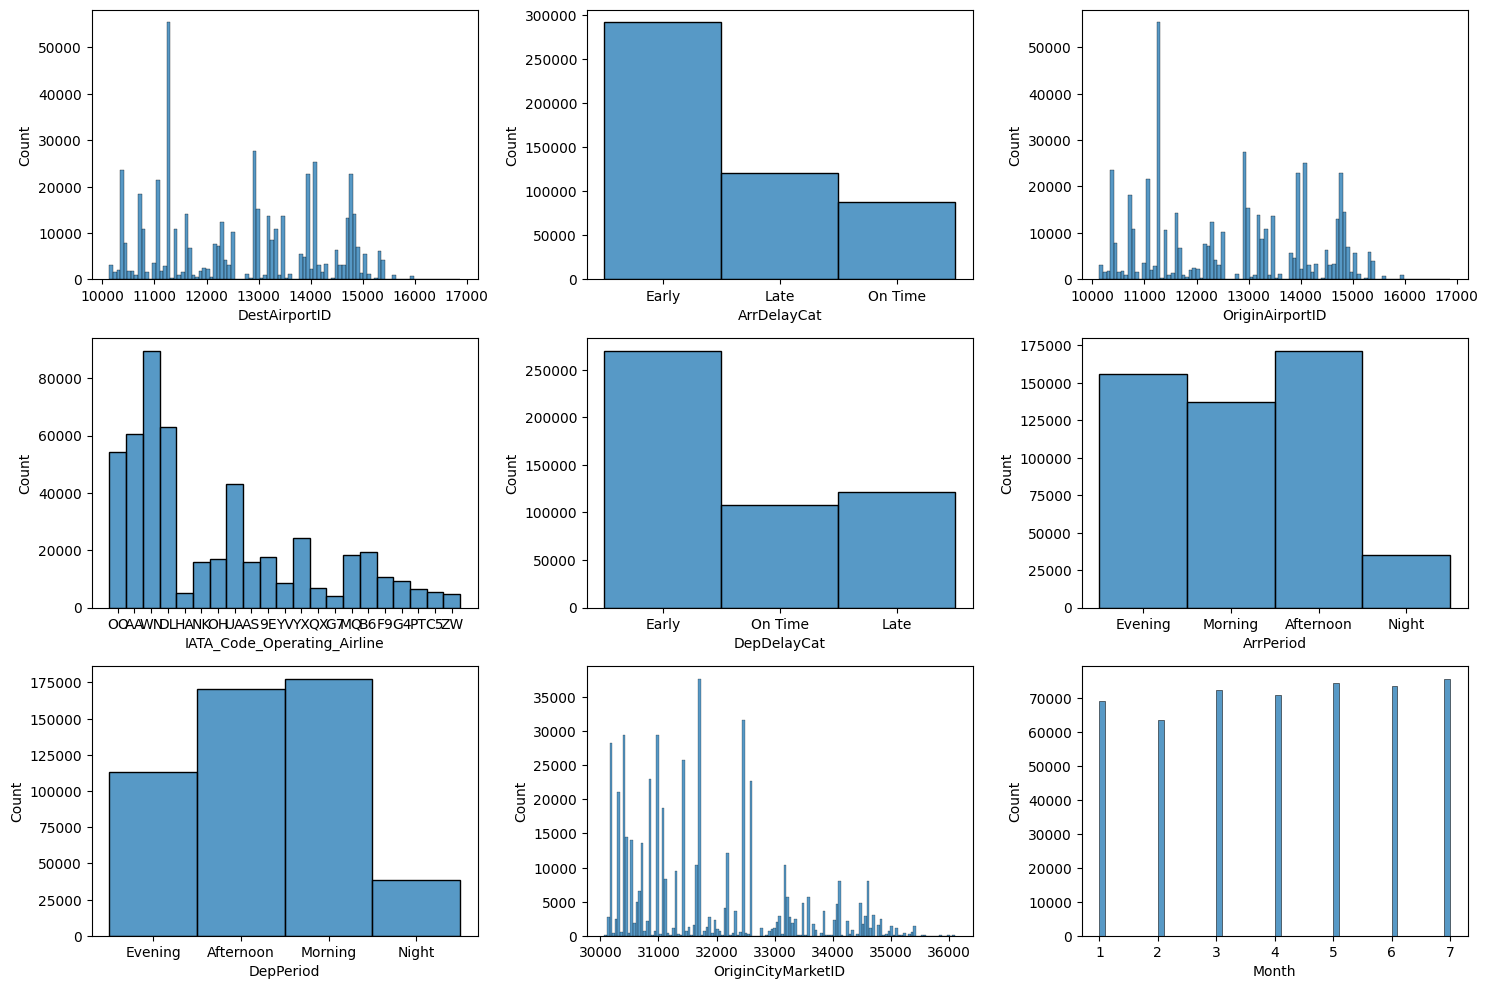

In [54]:
#Analysis on categorical values
fig, axis = plt.subplots(3, 3, figsize=(15, 10))

# Create Histogram
sns.histplot(ax = axis[0,0], data = df, x = "DestAirportID")
sns.histplot(ax = axis[0,1], data = df, x = "ArrDelayCat")
sns.histplot(ax = axis[0,2], data = df, x = "OriginAirportID")
sns.histplot(ax = axis[1,0], data = df, x = "IATA_Code_Operating_Airline")
sns.histplot(ax = axis[1,1], data = df, x = "DepDelayCat")
sns.histplot(ax = axis[1,2], data = df, x = "ArrPeriod")
sns.histplot(ax = axis[2,0], data = df, x = "DepPeriod")
sns.histplot(ax = axis[2,1], data = df, x = "OriginCityMarketID")
sns.histplot(ax = axis[2,2], data = df, x = "Month")

#fig.delaxes(axis[2, 2])

plt.tight_layout()

plt.show()

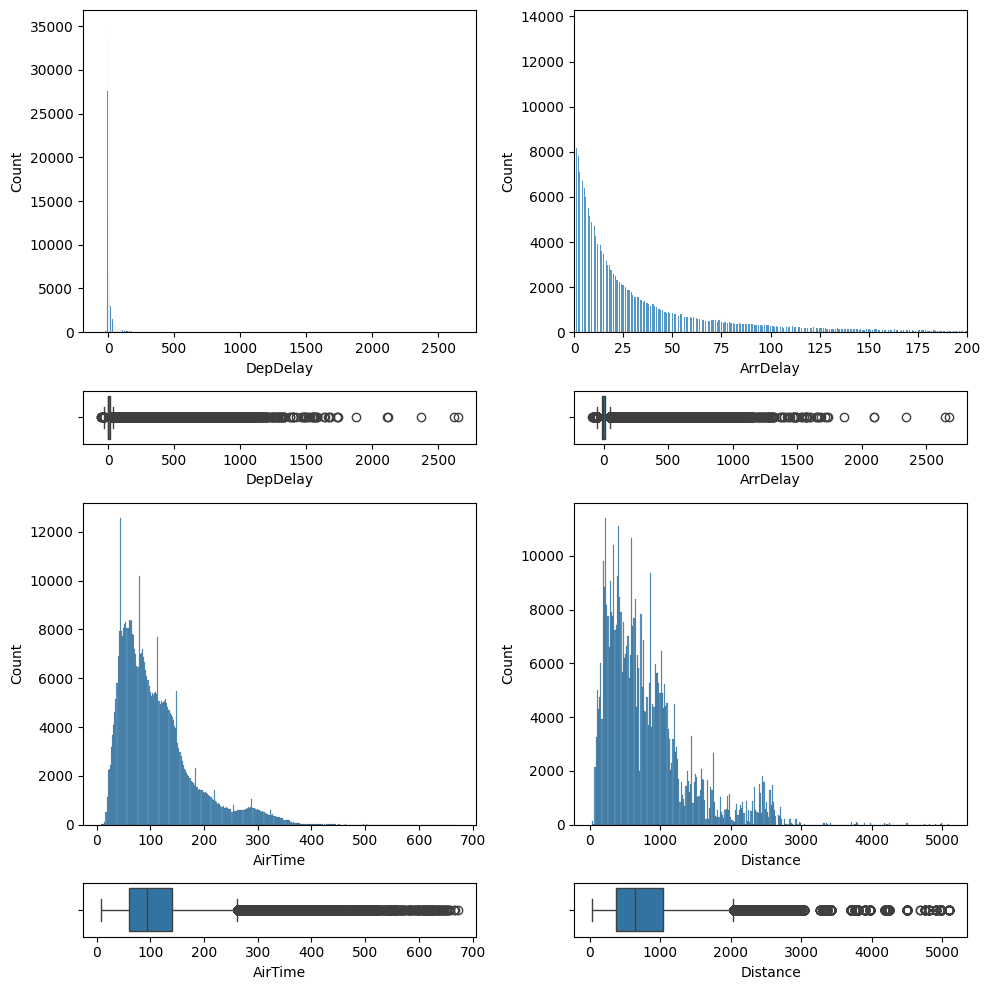

In [55]:
#Analysis on categorical values
ig, axis = plt.subplots(4, 2, figsize = (10, 10), gridspec_kw = {"height_ratios": [6, 1, 6, 1]})

sns.histplot(ax = axis[0, 0], data = df, x = "DepDelay")
sns.boxplot(ax = axis[1, 0], data = df, x = "DepDelay")

sns.histplot(ax = axis[0, 1], data = df, x = "ArrDelay").set_xlim(0, 200)
sns.boxplot(ax = axis[1, 1], data = df, x = "ArrDelay")

sns.histplot(ax = axis[2, 0], data = df, x = "AirTime")
sns.boxplot(ax = axis[3, 0], data = df, x = "AirTime")

sns.histplot(ax = axis[2,1], data = df, x = "Distance")
sns.boxplot(ax = axis[3, 1], data = df, x = "Distance")

plt.tight_layout()

plt.show()

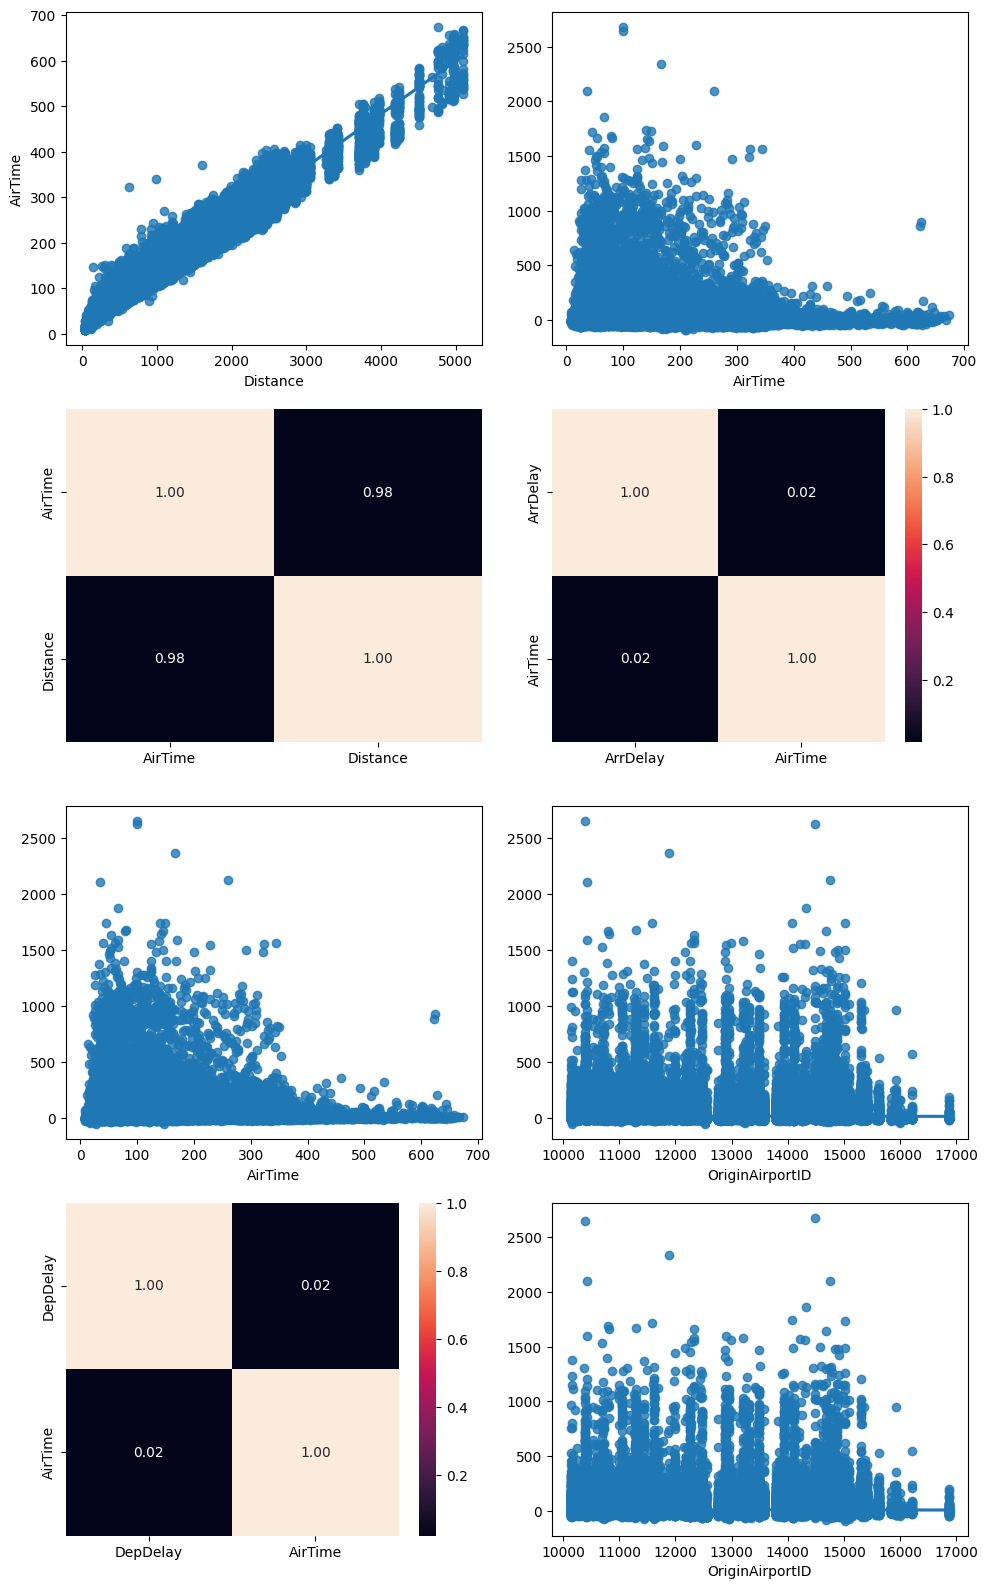

In [56]:
# Numerical - Numerical Analysis

# Create subplot canvas
fig, axis = plt.subplots(4, 2, figsize = (10, 16))

# Create Plates 
sns.regplot(ax = axis[0, 0], data = df, x = "Distance", y = "AirTime")
sns.heatmap(df[["AirTime", "Distance"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(ax = axis[0, 1], data = df, x = "AirTime", y = "ArrDelay").set(ylabel = None)
sns.heatmap(df[["ArrDelay", "AirTime"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[2, 0], data = df, x = "AirTime", y = "DepDelay").set(ylabel = None)
sns.heatmap(df[["DepDelay", "AirTime"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0]).set(ylabel = None)

sns.regplot(ax = axis[2, 1], data = df, x = "OriginAirportID", y = "DepDelay").set(ylabel = None)
sns.regplot(ax = axis[3, 1], data = df, x = "OriginAirportID", y = "ArrDelay").set(ylabel = None)

plt.tight_layout()

plt.show()

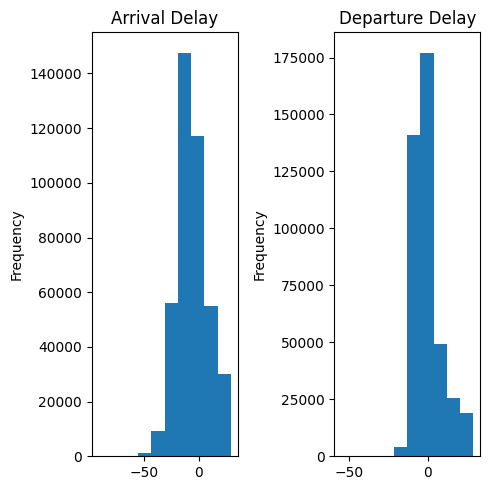

In [57]:
fig, axis = plt.subplots(1, 2, figsize = (5, 5))
df.query('ArrDelay < 30')['ArrDelay'].plot(kind='hist', ax=axis[0], title='Arrival Delay')
df.query('DepDelay < 30')['DepDelay'].plot(kind='hist', ax=axis[1], title='Departure Delay')
plt.tight_layout()

plt.show()

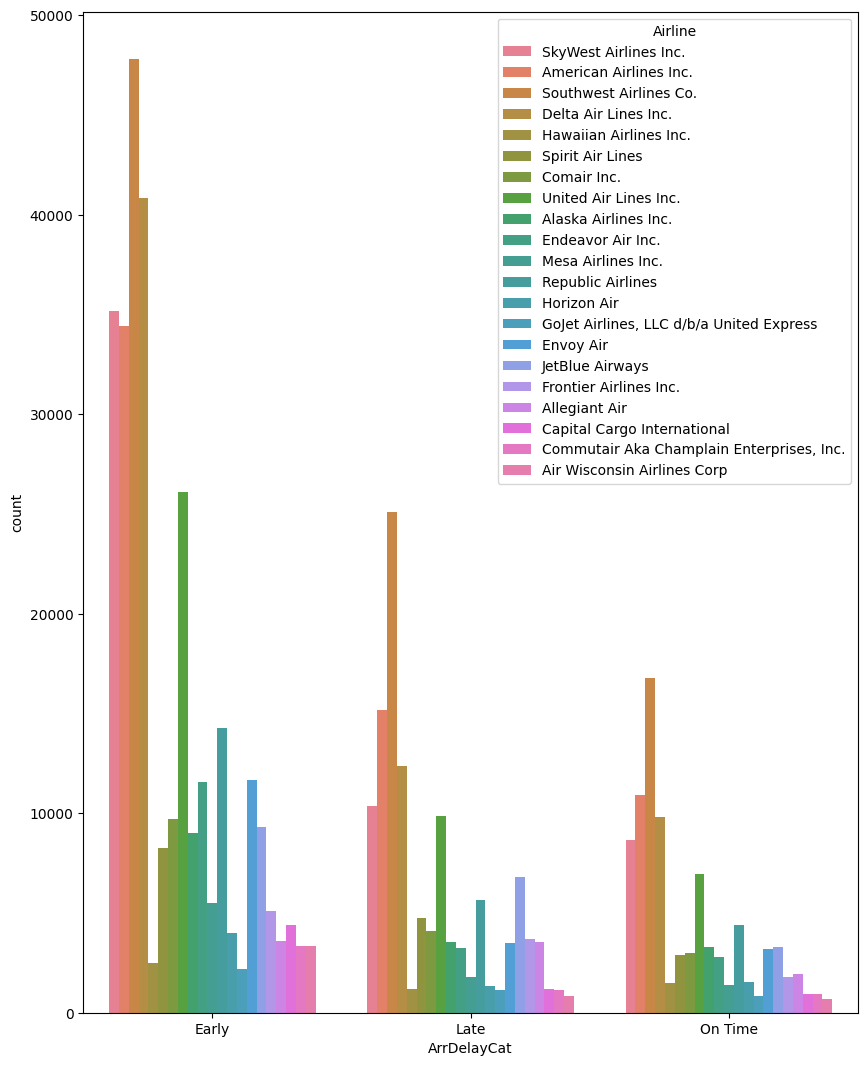

In [58]:
fig, axis = plt.subplots(figsize = (10, 13))

sns.countplot(data = df, x = "ArrDelayCat", hue = "Airline")

plt.show()

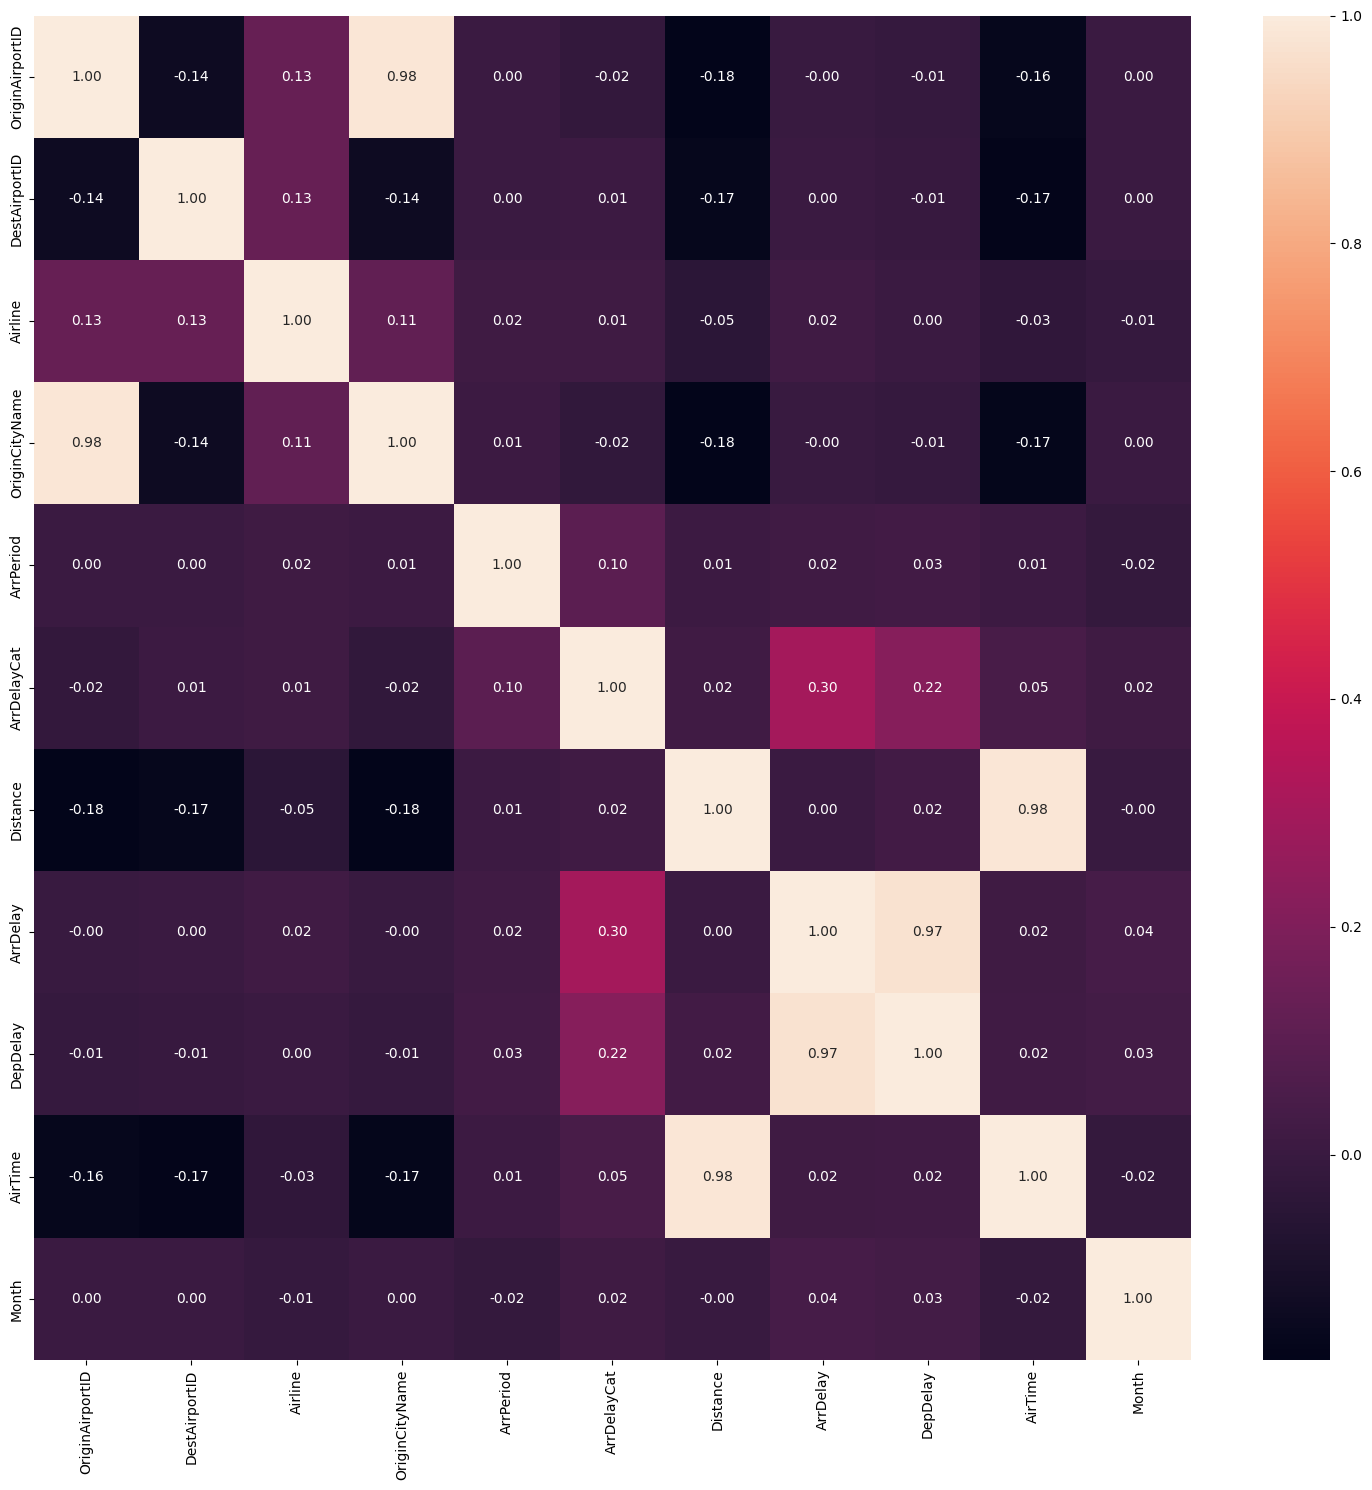

In [59]:
df["OriginAirportID"] = pd.factorize(df["OriginAirportID"])[0]
df["DestAirportID"] = pd.factorize(df["DestAirportID"])[0]
df["Airline"] = pd.factorize(df["Airline"])[0]
df["OriginCityName"] = pd.factorize(df["OriginCityName"])[0]
df["ArrDelayCat"] = pd.factorize(df["ArrDelayCat"])[0]
df["ArrPeriod"] = pd.factorize(df["ArrPeriod"])[0]

fig, axes = plt.subplots(figsize=(15, 15))

sns.heatmap(df[["OriginAirportID", "DestAirportID", "Airline", "OriginCityName", "ArrPeriod", "ArrDelayCat", "Distance", "ArrDelay", "DepDelay","AirTime", "Month"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

In [60]:
spearman_corr = df[['ArrDelayCat', 'ArrPeriod']].corr(method='spearman').iloc[0, 1]
print("Correlación de Spearman:", spearman_corr)


kendall_corr = df[['ArrDelayCat', 'ArrPeriod']].corr(method='kendall').iloc[0, 1]
print("Correlación de Kendall:", kendall_corr)


Correlación de Spearman: 0.06892309780107024
Correlación de Kendall: 0.0594189174115641


### Model Selection

In [148]:
model_dict = {
    'logistic_regression': LogisticRegression(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'xgboost': XGBClassifier(),
    #'knn': NearestNeighbors(),
    'SVC': SVC(max_iter=500)
}
# model_dict = {
#     'decision_tree': DecisionTreeRegressor(),
#     'random_forest': RandomForestRegressor(),
#     'xgboost': XGBRegressor(),
# }

In [149]:
new_df = df[["OriginAirportID", "DestAirportID", "Airline", "OriginCityName", "ArrPeriod", "ArrDelayCat", "Distance", "ArrDelay", "DepDelay","AirTime", "Month"]]

new_df.head()

,OriginAirportID,DestAirportID,Airline,OriginCityName,ArrPeriod,ArrDelayCat,Distance,ArrDelay,DepDelay,AirTime,Month
0,0,0,0,0,0,0,125,-10.0,-5.0,31.0,3
1,1,0,0,1,0,1,1162,35.0,0.0,194.0,2
2,2,1,1,2,0,2,2486,3.0,-5.0,314.0,1
3,3,2,2,3,0,1,2106,27.0,18.0,251.0,1
4,4,3,3,4,1,0,501,-16.0,-6.0,73.0,7


In [150]:
nan_columns = df.columns[df.isna().any()]
print("Columns with NaN values:")
print(nan_columns)


Columns with NaN values:
Index(['DepDelay', 'AirTime', 'ArrDelay'], dtype='object')


In [151]:
new_df.dropna()

,OriginAirportID,DestAirportID,Airline,OriginCityName,ArrPeriod,ArrDelayCat,Distance,ArrDelay,DepDelay,AirTime,Month
0,0,0,0,0,0,0,125,-10.0,-5.0,31.0,3
1,1,0,0,1,0,1,1162,35.0,0.0,194.0,2
2,2,1,1,2,0,2,2486,3.0,-5.0,314.0,1
3,3,2,2,3,0,1,2106,27.0,18.0,251.0,1
4,4,3,3,4,1,0,501,-16.0,-6.0,73.0,7
...,...,...,...,...,...,...,...,...,...,...,...
499995,84,113,4,81,0,2,102,0.0,0.0,22.0,3
499996,6,39,8,6,0,1,1448,26.0,5.0,218.0,2
499997,3,22,3,3,2,1,1749,16.0,34.0,193.0,5
499998,4,20,3,4,2,0,986,-20.0,-2.0,132.0,3


In [ ]:
['OriginAirportID',
 'DestAirportID',
 'Airline',
 'OriginCityName',
 'Distance',
 'AirTime',
 'Month']

In [152]:
new_df.columns

Index(['OriginAirportID', 'DestAirportID', 'Airline', 'OriginCityName',
       'ArrPeriod', 'ArrDelayCat', 'Distance', 'ArrDelay', 'DepDelay',
       'AirTime', 'Month'],
      dtype='object')

In [153]:
Selected_variables = ["OriginAirportID", "DestAirportID", "Airline", "OriginCityName", "ArrPeriod", "Distance", "ArrDelay", "DepDelay","AirTime", "Month"]
cols_for_model = [
    "OriginAirportID", 
    "DestAirportID", 
    "Airline", 
    "OriginCityName", 
    "Distance", 
    "AirTime", 
    "Month"
]

In [154]:
numeric_features = ['Distance', 'ArrDelay', 'DepDelay', 'AirTime']
categorical_features = [
    'OriginAirportID', 
    'DestAirportID', 
    'Airline', 
    'OriginCityName', 
    'ArrPeriod', 
]
target_var = 'ArrDelayCat'

y = new_df['ArrDelayCat']


In [155]:
scaler = RobustScaler()
scal_features = scaler.fit_transform(new_df[Selected_variables])
total_data_scal = pd.DataFrame(scal_features, index = new_df.index, columns = Selected_variables)
total_data_scal.head()

,OriginAirportID,DestAirportID,Airline,OriginCityName,ArrPeriod,Distance,ArrDelay,DepDelay,AirTime,Month
0,-0.516129,-0.677966,-0.428571,-0.457627,-0.5,-0.781109,-0.208333,-0.2500,-0.777778,-0.25
1,-0.500000,-0.677966,-0.428571,-0.440678,-0.5,0.773613,1.666667,0.0625,1.234568,-0.50
2,-0.483871,-0.661017,-0.285714,-0.423729,-0.5,2.758621,0.333333,-0.2500,2.716049,-0.75
3,-0.467742,-0.644068,-0.142857,-0.406780,-0.5,2.188906,1.333333,1.1875,1.938272,-0.75
4,-0.451613,-0.627119,0.000000,-0.389831,0.0,-0.217391,-0.458333,-0.3125,-0.259259,0.75


In [156]:
total_data_scal[target_var] = y

total_data_scal

,OriginAirportID,DestAirportID,Airline,OriginCityName,ArrPeriod,Distance,ArrDelay,DepDelay,AirTime,Month,ArrDelayCat
0,-0.516129,-0.677966,-0.428571,-0.457627,-0.5,-0.781109,-0.208333,-0.2500,-0.777778,-0.25,0
1,-0.500000,-0.677966,-0.428571,-0.440678,-0.5,0.773613,1.666667,0.0625,1.234568,-0.50,1
2,-0.483871,-0.661017,-0.285714,-0.423729,-0.5,2.758621,0.333333,-0.2500,2.716049,-0.75,2
3,-0.467742,-0.644068,-0.142857,-0.406780,-0.5,2.188906,1.333333,1.1875,1.938272,-0.75,1
4,-0.451613,-0.627119,0.000000,-0.389831,0.0,-0.217391,-0.458333,-0.3125,-0.259259,0.75,0
...,...,...,...,...,...,...,...,...,...,...,...
499995,0.838710,1.237288,0.142857,0.915254,-0.5,-0.815592,0.208333,0.0625,-0.888889,-0.25,2
499996,-0.419355,-0.016949,0.714286,-0.355932,-0.5,1.202399,1.291667,0.3750,1.530864,-0.50,1
499997,-0.467742,-0.305085,0.000000,-0.406780,0.5,1.653673,0.875000,2.1875,1.222222,0.25,1
499998,-0.451613,-0.338983,0.000000,-0.389831,0.5,0.509745,-0.625000,-0.0625,0.469136,-0.25,0


In [157]:
nan_columns = total_data_scal.columns[total_data_scal.isna().any()]

# Display the columns containing NaN values
print("Columns with NaN values:")
print(nan_columns)


Columns with NaN values:
Index(['ArrDelay', 'DepDelay', 'AirTime'], dtype='object')


In [158]:
#df_scaled = preprocessor.fit_transform(X)
total_data_scal= total_data_scal.dropna()

In [159]:
total_data_scal.columns

Index(['OriginAirportID', 'DestAirportID', 'Airline', 'OriginCityName',
       'ArrPeriod', 'Distance', 'ArrDelay', 'DepDelay', 'AirTime', 'Month',
       'ArrDelayCat'],
      dtype='object')

In [160]:
# columns = numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out())

# X_processed_df = pd.DataFrame(df_scaled, index = X.index, columns=Selected_variables)

In [161]:
total_data_scal.columns

Index(['OriginAirportID', 'DestAirportID', 'Airline', 'OriginCityName',
       'ArrPeriod', 'Distance', 'ArrDelay', 'DepDelay', 'AirTime', 'Month',
       'ArrDelayCat'],
      dtype='object')

In [162]:
total_data_scal.head()

,OriginAirportID,DestAirportID,Airline,OriginCityName,ArrPeriod,Distance,ArrDelay,DepDelay,AirTime,Month,ArrDelayCat
0,-0.516129,-0.677966,-0.428571,-0.457627,-0.5,-0.781109,-0.208333,-0.2500,-0.777778,-0.25,0
1,-0.500000,-0.677966,-0.428571,-0.440678,-0.5,0.773613,1.666667,0.0625,1.234568,-0.50,1
2,-0.483871,-0.661017,-0.285714,-0.423729,-0.5,2.758621,0.333333,-0.2500,2.716049,-0.75,2
3,-0.467742,-0.644068,-0.142857,-0.406780,-0.5,2.188906,1.333333,1.1875,1.938272,-0.75,1
4,-0.451613,-0.627119,0.000000,-0.389831,0.0,-0.217391,-0.458333,-0.3125,-0.259259,0.75,0


In [164]:
X = total_data_scal.drop("ArrDelayCat", axis = 1)
y = total_data_scal["ArrDelayCat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

selection_model = SelectKBest(score_func = f_classif, k = 7)
selection_model.fit(X_train, y_train)

selected_columns = cols_for_model
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = cols_for_model)
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = cols_for_model)


In [165]:
selected_columns

['OriginAirportID',
 'DestAirportID',
 'Airline',
 'OriginCityName',
 'Distance',
 'AirTime',
 'Month']

In [166]:
X_train_sel["ArrDelayCat"] = y_train.values
X_test_sel["ArrDelayCat"] = y_test.values
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)

In [167]:
train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")

In [168]:
X_train = train_data.drop(["ArrDelayCat"], axis = 1)
y_train = train_data["ArrDelayCat"]
X_test = test_data.drop(["ArrDelayCat"], axis = 1)
y_test = test_data["ArrDelayCat"]

y_train.unique()

array([0, 1, 2], dtype=int64)

In [169]:
X_train.columns

Index(['OriginAirportID', 'DestAirportID', 'Airline', 'OriginCityName',
       'Distance', 'AirTime', 'Month'],
      dtype='object')

In [170]:
# eval_dict = {
#     'decision_tree': {
#         'Intercept (a)': 0,
#         'Coefficients (b1, b2)': 0,
#         'mse': 0,
#         'r2_score': 0
#     },
#     'random_forest': {
#         'Intercept (a)': 0,
#         'Coefficients (b1, b2)': 0,
#         'mse': 0,
#         'r2_score': 0
#     },
#     'xgboost': {
#         'Intercept (a)': 0,
#         'Coefficients (b1, b2)': 0,
#         'mse': 0,
#         'r2_score': 0
#     },
# }
eval_dict = {
    'logistic_regression': {
        'Intercept (a)': 0,
        'Coefficients (b1, b2)': 0,
        'accuracy': 0
    },
    'decision_tree': {
        'Intercept (a)': 0,
        'Coefficients (b1, b2)': 0,
        'accuracy': 0
    },
    'random_forest': {
        'Intercept (a)': 0,
        'Coefficients (b1, b2)': 0,
        'accuracy': 0
    },
    'xgboost': {
        'Intercept (a)': 0,
        'Coefficients (b1, b2)': 0,
        'accuracy': 0
    },
    # 'knn': {
    #     'Intercept (a)': 0,
    #     'Coefficients (b1, b2)': 0,
    #     'mse': 0,
    #     'r2_score': 0
    # },
    'SVC': {
        'Intercept (a)': 0,
        'Coefficients (b1, b2)': 0,
        'accuracy': 0
    },
}

In [171]:
for mod in model_dict:
    model = model_dict[mod]
    print('|------------------------------|')
    print(f'| Model: {mod}')
    print('|------------------------------|')
    model.fit(X_train, y_train)
    try:
        eval_dict[mod]['Intercept (a)'] = model.intercept_
        eval_dict[mod]['Coefficients (b1, b2)'] = model.coef_
        eval_dict[mod]['accuracy'] = accuracy_score(y_test, model.predict(X_test))

    except AttributeError:
        eval_dict[mod]['accuracy'] = accuracy_score(y_test, model.predict(X_test))

    finally:
        eval_dict[mod]['accuracy'] = accuracy_score(y_test, model.predict(X_test))

|------------------------------|
| Model: logistic_regression
|------------------------------|
|------------------------------|
| Model: decision_tree
|------------------------------|
|------------------------------|
| Model: random_forest
|------------------------------|
|------------------------------|
| Model: xgboost
|------------------------------|
|------------------------------|
| Model: SVC
|------------------------------|


In [172]:
for i in eval_dict:
    print(f'| {i} |')
    print(eval_dict[i])
    print('\n')

| logistic_regression |
{'Intercept (a)': array([ 19.55951636, -24.33959604,   4.78007968]), 'Coefficients (b1, b2)': array([[ 1.20561586e-01, -1.23480353e-01, -1.06835811e-01,
        -6.73639471e+01, -6.17450102e-02,  8.75898299e-02,
         1.16670923e-02],
       [-3.67476275e-01,  3.62144059e-01, -1.26229575e-01,
         5.60889398e+01,  8.69592011e-02,  1.44116821e-01,
        -4.24581666e-03],
       [ 2.46914689e-01, -2.38663707e-01,  2.33065385e-01,
         1.12750073e+01, -2.52141909e-02, -2.31706651e-01,
        -7.42127563e-03]]), 'accuracy': 0.9998656539037876}


| decision_tree |
{'Intercept (a)': 0, 'Coefficients (b1, b2)': 0, 'accuracy': 1.0}


| random_forest |
{'Intercept (a)': 0, 'Coefficients (b1, b2)': 0, 'accuracy': 1.0}


| xgboost |
{'Intercept (a)': 0, 'Coefficients (b1, b2)': 0, 'accuracy': 1.0}


| SVC |
{'Intercept (a)': array([-0.8346984 ,  0.16258677,  0.23892021]), 'Coefficients (b1, b2)': 0, 'accuracy': 0.9168501007595722}




In [173]:
model_dict['SVC'].get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 500,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Model Build - GridSearchCV

In [174]:
hps = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1],
    'max_iter': [500, 1000, 2000]
}

In [175]:
# rand_search = RandomizedSearchCV(
#     SVC(),
#     param_distributions = hps,
#     scoring = 'accuracy',
#     cv = 10
# )

# rand_search.fit(X_train, y_train)

# grid_search = GridSearchCV(
#     SVC(),
#     param_grid = hps,
#     scoring = 'accuracy',
#     cv = 10,
#     verbose = 4
# )

# grid_search.fit(X_train, y_train)

In [176]:
rand_search = RandomizedSearchCV(
    SVC(),
    param_distributions = hps,
    scoring = 'accuracy',
    cv = 5,
    verbose = 4
)

rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV 1/5] END C=1, gamma=0.001, kernel=rbf, max_iter=1000;, score=0.981 total time= 1.4min
[CV 2/5] END C=1, gamma=0.001, kernel=rbf, max_iter=1000;, score=0.950 total time= 1.4min
[CV 3/5] END C=1, gamma=0.001, kernel=rbf, max_iter=1000;, score=0.984 total time= 1.4min
[CV 4/5] END C=1, gamma=0.001, kernel=rbf, max_iter=1000;, score=0.972 total time= 1.4min
[CV 5/5] END C=1, gamma=0.001, kernel=rbf, max_iter=1000;, score=0.975 total time= 1.4min
[CV 1/5] END C=10, gamma=0.001, kernel=linear, max_iter=1000;, score=1.000 total time=   7.1s
[CV 2/5] END C=10, gamma=0.001, kernel=linear, max_iter=1000;, score=1.000 total time=   6.8s
[CV 3/5] END C=10, gamma=0.001, kernel=linear, max_iter=1000;, score=1.000 total time=   6.7s
[CV 4/5] END C=10, gamma=0.001, kernel=linear, max_iter=1000;, score=1.000 total time=   6.8s
[CV 5/5] END C=10, gamma=0.001, kernel=linear, max_iter=1000;, score=1.000 total time=   7.0s
[CV 1/5] END C=1, gamma=0.1, kernel=linear, max_iter=2000;, score=1.000 total ti

RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': [0.001, 0.01, 0.1, 1],
                                        'kernel': ['linear', 'rbf'],
                                        'max_iter': [500, 1000, 2000]},
                   scoring='accuracy', verbose=4)

In [177]:
#grid_search.best_params_
rand_best_params = rand_search.best_params_

In [178]:
rand_best_params

{'max_iter': 1000, 'kernel': 'linear', 'gamma': 0.001, 'C': 10}

In [190]:
#best_params = {'max_iter': 1000, 'kernel': 'linear', 'gamma': 0.001, 'C': 10}
best_params = {
    'C':1, 
    'gamma':0.001, 
    'kernel':'rbf', 
    'max_iter':500
}

### Model Tuning - Training and Predictions

In [180]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [181]:
tuned_evaluations = {
    'train': 0,
    'validation': 0,
    'test': 0
}

In [191]:
svc_model = SVC(
    C = best_params['C'],
    kernel = best_params['kernel'],
    gamma = best_params['gamma'],
    max_iter = best_params['max_iter'],
    random_state = 42
)

In [192]:
svc_model.fit(X_train, y_train)

SVC(C=1, gamma=0.001, max_iter=500, random_state=42)

In [193]:

for eval in tuned_evaluations:
    if eval == 'train':
        tuned_evaluations[eval] = accuracy_score(
            y_train, svc_model.predict(X_train)
        )
    if eval == 'validation':
        tuned_evaluations[eval] = accuracy_score(
            y_val, svc_model.predict(X_val)
        )
    if eval == 'test':
        tuned_evaluations[eval] = accuracy_score(
            y_test, svc_model.predict(X_test)
        )

In [194]:
for metric in tuned_evaluations:
    print(f'{metric} set accuracy: {tuned_evaluations[metric]}')

train set accuracy: 0.9738348059732341
validation set accuracy: 0.9737766754508345
test set accuracy: 0.973854182814034


In [196]:
svc_model.predict(X_test)

array([0, 0, 2, ..., 0, 2, 2], dtype=int64)

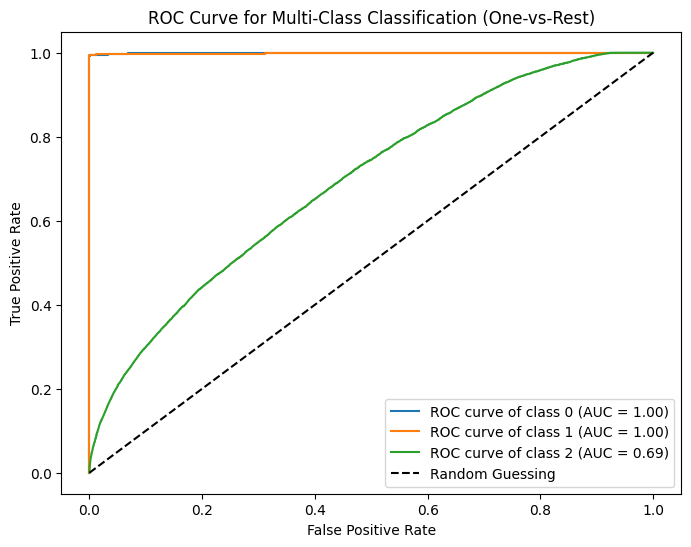

In [195]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create One-vs-Rest classifier
ovr_classifier = OneVsRestClassifier(svc_model)

# Fit the classifier on the training data
ovr_classifier.fit(X_train, y_train)

# Get decision function scores for each class
y_scores = ovr_classifier.decision_function(X_test)

# Convert pandas Series to numpy array
y_test_np = y_test.values

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(pd.unique(y_train))):
    fpr[i], tpr[i], _ = roc_curve((y_test_np == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(pd.unique(y_train))):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()



### Saving the Model
Before running the following cell we MUST push the changes from the fine tuning and fine tuned training and predictions

In [197]:
dump(svc_model, open("../models/svc_model-C-1_gamma-001_kernel-rbf_max-iter-500_rand-state-42.sav", "wb"))